#  Seminar. Uncertainty in Deep Learning
1. Uncerainty estimation problem statement
2. Bayesian linear regression
3. Bayesian NN
4. ...

### Uncertainty in classification

% Написать про предиктивное распределение, типы неопределённости,

### Monte Carlo dropout

<AxesSubplot:xlabel='x', ylabel='label'>

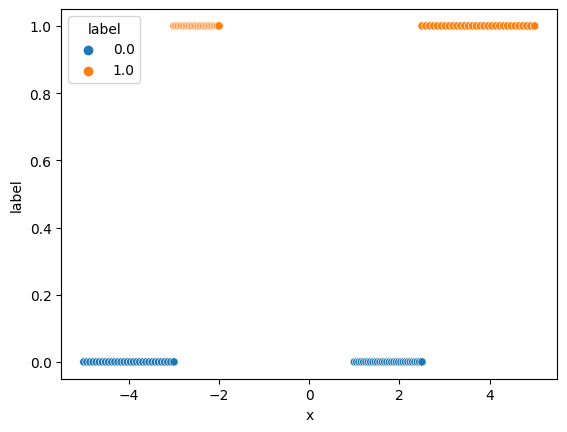

In [72]:
import torch
from torch import nn
import numpy as np
import seaborn as sns
from torch.optim.lr_scheduler import OneCycleLR
import math

# Genetate toy data
end_points = {
    0: [[-5, -3], [1, 2.5]],
              1: [[-3, -2], [2.5, 5]]
}
data = []
num_points_per_interval = 30
for class_id, intervals in end_points.items():
    for interval in intervals:
        xs = np.linspace(*interval, num_points_per_interval)
        ys = np.array([class_id] * num_points_per_interval)
        data.append(np.concatenate([xs[:,np.newaxis], ys[:,np.newaxis]], axis=1))
data = np.concatenate(data, axis=0)
data_to_vis = {"x": data[:,0],
               "label": data[:,1]}
sns.scatterplot(data=data_to_vis, x="x", y="label", hue="label")

In [ ]:
x = torch.tensor(data[:,0], dtype=torch.float)[:,None]

x_norm = (x - torch.min(x))/(torch.max(x) - torch.min(x))
y = torch.tensor(data[:,1], dtype=torch.float)[:,None]


# Use the nn package to define our model and loss function.
dropout_p = 0.2
nn.functional.dropout
model = torch.nn.Sequential(
    torch.nn.Linear(1, 10),
    #nn.Dropout(p=dropout_p),
    nn.Sigmoid(),
    torch.nn.Linear(10, 50),
    nn.Dropout(p=dropout_p),
    nn.Sigmoid(),
    torch.nn.Linear(50, 20),
    nn.Sigmoid(),
    torch.nn.Linear(20, 1),
    nn.Flatten(),
    nn.Sigmoid(),
)

loss_fn = nn.BCELoss()

learning_rate = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 1e-4)

epochs = 4000
scheduler = OneCycleLR(optimizer, max_lr = 1e-1,
            steps_per_epoch = 1,
            epochs = epochs,
            div_factor = 1e1,
            final_div_factor = 1e2)
for t in range(epochs):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x_norm)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    if t % 500 == 0:
        print(t, loss.item())
        #print(scheduler.get_lr())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

0 0.6993047595024109
500 0.1158580482006073
1000 0.06668312102556229
1500 0.05805406719446182
2000 0.06499035656452179
2500 0.04774828255176544
3000 0.054138608276844025
3500 0.04261593893170357


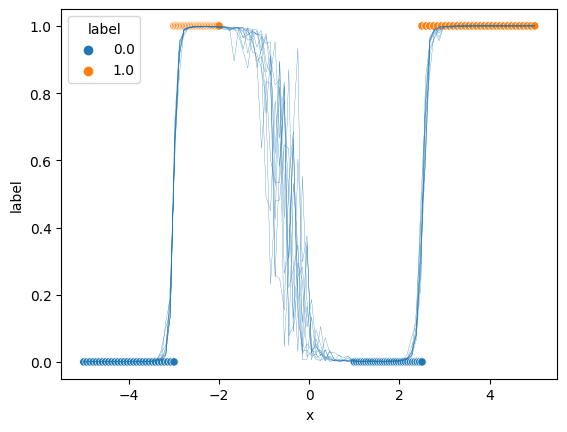

In [83]:
import matplotlib.pyplot as plt

x_test = torch.linspace(-5, 5, 100)[:,None]
x_test_norm = (x_test - torch.min(x))/(torch.max(x) - torch.min(x))
num_sample = 10

data_to_vis = {"x": data[:,0],
               "label": data[:,1]}
sns.scatterplot(data=data_to_vis, x="x", y="label", hue="label")

for _ in range(num_sample):
    #model.eval()
    model.train()
    p_pred = model(x_test_norm)
    plt.plot(x_test[:,0], p_pred[:,0].detach().numpy(), color="tab:blue", linewidth=0.2)

In [5]:
1

1

### 1. Logistic and probit regression. Bayesian logistic regression. Laplace approximation

#### 1.1 Classification problem
The natural starting point for discussing approaches to classification is the joint probability $p(y, \mathbf{x})$, where $y$ denotes the class label. Using Bayes' theorem this joint probability can be decomposed either as $p(y) p(\mathbf{x}|y)$ or as $p(\mathbf{x}) p(y|\mathbf{x})$. This gives rise to two different approaches to classification problems. The first, which we call the generative approach, models the class-conditional distributions $p(\mathbf{x}|y)$ for $y=\mathcal{C}_1, \ldots, \mathcal{C}_C$ and also the prior probabilities of each class, and then computes the posterior probability for each class using

$$
p(y|\mathbf{x})=\frac{p(y) p(\mathbf{x}|y)}{\sum_{c=1}^C p\left(\mathcal{C}_c\right) p\left(\mathbf{x}|\mathcal{C}_c\right)}
$$


The alternative approach, which we call the discriminative approach, focusses on modelling $p(y|\mathbf{x})$ directly.  
To turn both the generative and discriminative approaches into practical methods we will need to create models for either $p(\mathbf{x}|y)$, or $p(y|\mathbf{x})$ respectively.
#### 1.2 Logistic and probit regression
##### 1.2.1 Modeling
For the binary discriminative case one simple idea is to turn the output of a regression model into a class probability using a response function (the inverse of a link function), which "squashes" its argument, which can lie in the domain $(-\infty, \infty)$, into the range $[0,1]$, guaranteeing a valid probabilistic interpretation.

One example is the **linear logistic regression** model

$$
p\left(y=1|\mathbf{x}, \boldsymbol{\theta}\right)=\lambda\left(\mathbf{x}^{\top} \boldsymbol{\theta}\right), \quad \text { where } \lambda(z)=\frac{1}{1+\exp (-z)}, \quad \mathbf{x},\boldsymbol{\theta}\in \mathbb{R}^D,\, y\in\{0,1\}
$$

which combines the linear model with the logistic response function. Another common choice of response function is the cumulative density function of a standard normal distribution $\Phi(z)=\int_{-\infty}^z \mathcal{N}(x|0,1) d x$. This approach is known as **probit regression**.

We have datasets $\mathcal{D} = \{(\mathbf{x}_i, y_i)\}_{i=1}^n,\, \text{where } \mathbf{x}_i, y_i\sim p(\mathbf{x}, y)$ $-$ iid samples.
Assuming that $\mathbf{x}$ is a uniformly distributed on finite support random value, we can write down probability of observed data given parameters $\boldsymbol{\theta}$, i.e *likelihood*:

$$
\mathcal{L}(\boldsymbol{\theta})=p(\mathcal{D}|\boldsymbol{\theta}) = p((\mathbf{x}_1, y_1),\dots,(\mathbf{x}_n, y_n)|\boldsymbol{\theta}) \underset{\text{iid}}{=} \prod_{i=1}^n p(\mathbf{x}_i,y_i|\boldsymbol{\theta}) = \prod_{i=1}^n p(y_i|\mathbf{x}_i, \boldsymbol{\theta})p(\mathbf{x}_i) = C\prod_{i=1}^n p(y_i|\mathbf{x}_i, \boldsymbol{\theta}), \quad \text{where } C = c^n,\, c - \text{constant dencity of }\mathbf{x}_i
$$

In linear logistic regression approach, we model class probabilities in following way:  
$p(y=1|\mathbf{x}_i, \boldsymbol{\theta}) = \lambda\left(\mathbf{x}_i^{\top} \boldsymbol{\theta}\right)\equiv p_i$,  
$p(y=0|\mathbf{x}_i,\boldsymbol{\theta}) = 1-\lambda\left(\mathbf{x}_i^{\top} \boldsymbol{\theta}\right)\equiv 1 - p_i$

With this model and notation, we can rewrite likelihood:
$$
\mathcal{L}(\boldsymbol{\theta}) = C\prod_{i=1}^n p^{y_i}_i(1-p_i)^{1-y_i}
$$ 

##### 1.2.2 MLE arroach
We can assume that papameters $\boldsymbol{\theta}$ are deterministic and unknown. We want to find most suited values $\boldsymbol{\theta}^*$. With assumptions above, a reasonable value would be Maximum Likelihood Estimate (MLE):

$$
\boldsymbol{\theta}^* = \underset{\boldsymbol{\theta}}{\text{argmax }}\mathcal{L}(\boldsymbol{\theta})
$$
which yield estimate with highest observed data probability.

$$
\underset{\boldsymbol{\theta}}{\text{argmax }}\mathcal{L}(\boldsymbol{\theta}) = \underset{\boldsymbol{\theta}}{\text{argmax }}\log p(\mathcal{D}|\boldsymbol{\theta}) = \underset{\boldsymbol{\theta}}{\text{argmax }} \sum^n_{i=1} y_i\log p_i + (1-y_i)\log (1-p_i)
$$

$$
\frac{\partial}{\partial \theta_j} \log p(\mathcal{D}|\boldsymbol{\theta}) = \sum_{i=1}^n\left[ \frac{y_i}{p_i}\frac{\partial}{\partial \theta_j}p_i - \frac{1-y_i}{1-p_i}\frac{\partial}{\partial \theta_j}p_i\right]
$$

$$
\frac{\partial}{\partial \theta_j}p_i = x_{ij}p_i(1-p_i)
$$

$$
\frac{\partial}{\partial \theta_j} \log p(\mathcal{D}|\boldsymbol{\theta}) =\sum_{i=1}^n x_{ij}\left[ \frac{y_i}{p_i}\frac{\partial}{\partial \theta_j}p_i - \frac{1-y_i}{1-p_i}\frac{\partial}{\partial \theta_j}p_i\right] = \sum_{i=1}^n x_{ij}\left[y_i-p_i\right]
$$

$$
\nabla_{\boldsymbol{\theta}}\log p(\mathcal{D}|\boldsymbol{\theta}) = \sum_{i=1}^n \mathbf{x}_{i}\left[y_i-p_i\right]
$$

$$
H(\boldsymbol{\theta}) = \frac{\partial}{\partial \theta_j \partial \theta_k} \log p(\mathcal{D}|\boldsymbol{\theta}) = -\sum_{i=1}^n x_{ij}x_{ik}p_i(1-p_i) = -X^TRX,\quad R=\text{diag}(p_i(1-p_i))
$$

We see, that Hessian is negative defines, thus optimization objective is concave.  
Convex optimization MLE:

$$
\boldsymbol{\theta}^{\text{new}} = \boldsymbol{\theta}^{\text{old}} + H^{-1}(\boldsymbol{\theta}^{\text{old}})\nabla_{\boldsymbol{\theta}^{\text{old}}}\log p(\mathcal{D}|\boldsymbol{\theta}^{\text{old}})
$$


#### 1.3 Bayesian linear logistic regression. Laplace approximation

Following bayesian linear regression, we want to incert some domaine knowledge and put prior on model parameters:
$$
\boldsymbol{\theta} \sim p(\boldsymbol{\theta})
$$

In order to obtain predictive model, one should marginalize $\boldsymbol{\theta}$ using posterior distribution $p(\boldsymbol{\theta}|\mathcal{D})$:
$$
p(y|\mathbf{x}, \mathcal{D}) = \int_{\boldsymbol{\theta}}p(y|\mathbf{x}, \boldsymbol{\theta})p(\boldsymbol{\theta}|\mathcal{D})d\boldsymbol{\theta}
$$

$$
p(\boldsymbol{\theta}|\mathcal{D}) = \frac{p(\mathcal{D}|\boldsymbol{\theta})p(\boldsymbol{\theta})}{p(\mathcal{D})}, \quad \text{where } p(\mathcal{D})=\int_{\boldsymbol{\theta}}p(\mathcal{D}|\boldsymbol{\theta})p(\boldsymbol{\theta})d\boldsymbol{\theta}
$$

It is hard to compute porterior distribution $p(\boldsymbol{\theta}|\mathcal{D})$, due to difficulty of evidence computatation $p(\mathcal{D})$.

##### 1.3.1 Laplace approximation

We could approximate $p(\boldsymbol{\theta}|\mathcal{D})$ with some distribution $q(\boldsymbol{\theta})$. Then
$$
p(y|\mathbf{x}, \mathcal{D})\approx \int_{\boldsymbol{\theta}}p(y|\mathbf{x}, \boldsymbol{\theta})q(\boldsymbol{\theta})d\boldsymbol{\theta}
$$

Let
$$
p(z) = \frac{1}{Z}f(z), \quad Z=\int_{z}f(z)dz
$$
In our task, $z=\boldsymbol{\theta}, f(\boldsymbol{\theta}) = p(\mathcal{D}|\boldsymbol{\theta})p(\boldsymbol{\theta})$

We want to find $q(z)\approx p(z)$
1. $\left.\frac{\partial f(z)}{\partial z}\right|_{z=z_0}=0$
2. $\log f(z)\approx \log f(z_0) - \frac{1}{2}(z-z_0)^TA(z-z_0)$, $\quad A=-\left.\nabla^2_{z}\log f(z)\right|_{z=z_0}$

So
$$
f(z)\approx f(z_0)\exp\left(-\frac{1}{2}(z-z_0)^TA(z-z_0)\right)\Rightarrow Z \approx \int_{z}f(z_0)\exp\left(-\frac{1}{2}(z-z_0)^TA(z-z_0)\right)dz
$$

$$
q(z) \sim \mathcal{N}(z|z_0, A^{-1})
$$

Drawbacks:
1. Local
2. Unimodal

##### 1.3.2 Bayesian linear logistic regression with Laplace approximation

$$
p(\boldsymbol{\theta}) \sim \mathcal{N}(\boldsymbol{\theta}|\boldsymbol{\mu}, S_0)
$$

$$
p(\boldsymbol{\theta}|\mathcal{D}) \propto p(\mathcal{D}|\boldsymbol{\theta})p(\boldsymbol{\theta})
$$
$$
\log p(\boldsymbol{\theta}|\mathcal{D}) \propto \sum^n_{i=1}\left[ y_i\log p_i + (1-y_i)\log (1-p_i)\right] - \frac{1}{2}(\boldsymbol{\theta} - \boldsymbol{\mu})^TS_0^{-1}(\boldsymbol{\theta} - \boldsymbol{\mu}), \quad \text{where }p_{i} = \lambda(\boldsymbol{\theta}^T\mathbf{x}_i)
$$
Laplace approximation:
$$
p(\boldsymbol{\theta}|\mathcal{D}) \approx q(\boldsymbol{\theta}) \sim \mathcal{N}(\boldsymbol{\theta}|\boldsymbol{\theta}_{\text{MAP}}, S_n)
$$

$$
S_n = -\nabla^2_{\boldsymbol{\theta}}\log p(\boldsymbol{\theta}|\mathcal{D}) = \sum_{i=1}^n x_ix_i^Tp_i(1-p_i) + S_0^{-1} = X^TRX + S_0^{-1},\quad R=\text{diag}(p_i(1-p_i))
$$

Predictive distribution:
$$
p(y=1|\mathbf{x}, \mathcal{D}) = \int_{\boldsymbol{\theta}}p(y=1|\mathbf{x}, \boldsymbol{\theta})p(\boldsymbol{\theta}|\mathcal{D})d\boldsymbol{\theta}\approx \int_{\boldsymbol{\theta}}\underbrace{p(y|\mathbf{x}, \boldsymbol{\theta})}_{\lambda(\boldsymbol{\theta}^T\mathbf{x})}q(\boldsymbol{\theta})d\boldsymbol{\theta}
$$

### 2. Relevance vector machine (RVM)